In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

In [2]:
base_dir = ("/home/kilian/rli/PC50/storage/open_bea_calculations_v4"
            "/edisgo_files/{}/ego100/dumb/timeseries")

topo_path = ("/home/kilian/rli/PC50/storage/open_bea_calculations_v4"
             "/edisgo_files/{}/ego100/dumb/topology/generators.csv")

f_load = "loads_active_power.csv"
f_cps = "charging_points_active_power.csv"

grid_ids = [176, 177, 1056, 1690, 1811, 2534]

f_result = "ev_peak_load_and_gen_per_grid.csv"

In [3]:
def read_csv_with_dtype(path, dtype="float32"):
    head = pd.read_csv(
        path, index_col=0, nrows=0)

    dtypes = {col: dtype for col in head.columns}
    
    return pd.read_csv(
        path, index_col=0, parse_dates=True, dtype=dtypes)

In [4]:
try:
    results_df = pd.read_csv(
        f_result, index_col=0)
except:
    columns = ["solar_cap", "wind_cap", "other_cap", "peak_load", "ev_peak_load"]

    results_df = pd.DataFrame(
        data=0., index=grid_ids, columns=columns)

    for grid_id in tqdm(grid_ids):
        topo_dir = topo_path.format(grid_id)
        grid_dir = base_dir.format(grid_id)

        topo_df = pd.read_csv(
            topo_dir, index_col=0)

        solar_cap = topo_df.loc[
            topo_df.type == "solar"].p_nom.sum()

        wind_cap = topo_df.loc[
            topo_df.type == "wind"].p_nom.sum()

        other_cap = topo_df.loc[
            ~topo_df.type.isin(["solar", "wind"])].p_nom.sum()

        peak_load = read_csv_with_dtype(os.path.join(
            grid_dir, f_load)).sum(axis=1).max()

        ev_peak_load = read_csv_with_dtype(os.path.join(
            grid_dir, f_cps)).sum(axis=1).max()

        results_df.loc[grid_id] = [
            solar_cap, wind_cap, other_cap, -peak_load, -ev_peak_load]
    
    results_df.to_csv(f_result)

In [5]:
results_df

,solar_cap,wind_cap,other_cap,peak_load,ev_peak_load
176,60.637955,6.277,15.435898,-36.591061,-6.799198
177,23.581556,0.000,0.491826,-47.930820,-6.605006
1056,99.174842,8.311,2.741945,-12.126625,-2.754598
1690,38.388070,138.173,50.052170,-12.956071,-3.141198
1811,23.614780,125.350,26.487895,-14.373480,-3.801897
2534,17.994794,0.000,0.000000,-62.125603,-3.966099


# Plots

In [6]:
import matplotlib as mpl
import seaborn as sns
# SSL to load seaborn example data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Locale settings
import locale
# Set to German locale to get comma decimal seperator
# Check with "locale -a" if "de_DE.utf8" is installed on your system
# Installation guide: https://ubuntuforums.org/showthread.php?t=196414
locale.setlocale(locale.LC_NUMERIC, "de_DE.utf8")

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import rgb2hex

# Tell matplotlib to use the locale
plt.rcParams['axes.formatter.use_locale'] = True

In [7]:
def RGB_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

In [8]:
# Plot parameters
# Style
style = "whitegrid"
# Figure sizes
standard_sizes = {
    "a4portrait": (8.27, 11.69),
    "a4landscape": (11.69, 8.27),
    "a5portrait": (5.8, 8.3),
    "a5landscape": (8.3, 5.8),
}
# Font parameters
font = "Latin Modern Roman"
font_scale = 1.5
# Figure aesthetics
grid_linestyle = "--"
yticks = True
xticks = True
# Colors
palette = sns.color_palette("colorblind")

rgb_grid = (200, 200, 200)
rgb_labels = (0, 0, 0)

hex_grid = RGB_to_hex(*rgb_grid)
hex_labels = RGB_to_hex(*rgb_labels)

palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [9]:
# Set seaborn parameters
rc_theme = {
    "grid.linestyle":grid_linestyle,
    "ytick.left":yticks,
    "xtick.bottom":xticks,
    "ytick.color":hex_grid,
    "ytick.labelcolor":hex_labels,
    "xtick.color":hex_grid,
    "xtick.labelcolor":hex_labels,
    "grid.color":hex_grid,
}

sns.set_theme(
    style=style, font=font, font_scale=font_scale, palette=palette, rc=rc_theme)

In [10]:
figure_export_as = ["png", "jpg"]
export_dir = "/home/kilian/rli/rl-institut/05_Temp/Kilian/open_bea/plots_Abschlussbericht"

os.makedirs(export_dir, exist_ok=True)

In [11]:
sorting_dict = {
    176: 2,
    177: 1,
    1056: 3,
    1690: 5,
    1811: 4,
    2534: 0}

order = ["wind_cap", "solar_cap", "other_cap", "peak_load", "ev_peak_load"]

In [12]:
kind_dict = {
    176: "PV",
    177: "L",
    1056: "PV",
    1690: "W",
    1811: "W",
    2534: "L"}

naming_dict = {key: f"$\mathregular{{{key}_{{{kind_dict[key]}}}}}$"
               for key in results_df.index}
naming_dict

{176: '$\\mathregular{176_{PV}}$',
 177: '$\\mathregular{177_{L}}$',
 1056: '$\\mathregular{1056_{PV}}$',
 1690: '$\\mathregular{1690_{W}}$',
 1811: '$\\mathregular{1811_{W}}$',
 2534: '$\\mathregular{2534_{L}}$'}

In [13]:
new_labels = ["Wind-Kapazitäten", "PV-Kapazitäten", "Sonst. EE-Kapazitäten", "Spitzenlast exkl. E-Mobilität", "Spitzenlast E-Mobilität"]

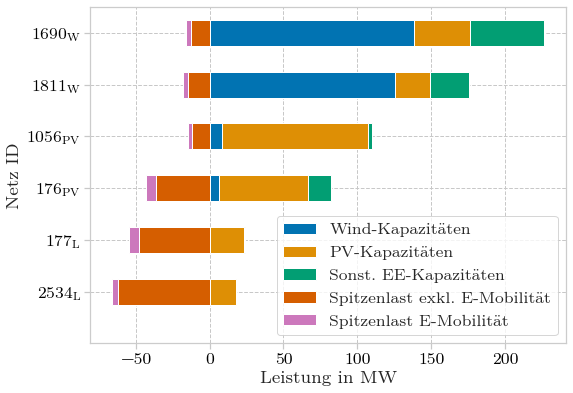

In [14]:
fig, ax = plt.subplots(figsize=standard_sizes["a5landscape"])

plt_df = results_df.sort_index(
    key=lambda x: x.map(sorting_dict))[order]

plt_df.plot(
    kind="barh", stacked=True, legend=True, ax=ax)

# plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

ax.set_xlabel("Leistung in MW")
ax.set_ylabel("Netz ID")

labels = [naming_dict[int(item.get_text())] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles, labels=new_labels)

# xlim = ax.get_xlim()
# xlim = (xlim[0], xlim[1]*1.1)
# ax.set_xlim(xlim)

ax.set_ylim((-1, 5.5))

plt.tight_layout()

for kind in figure_export_as:
    plt.savefig(
        os.path.join(export_dir, f"open_bea_grids_characteristics.{kind}"),
        dpi=450, bbox_inches="tight")

plt.show()